In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
import math

def env():
    # 系统矩阵A，B
    A = np.array([[0, 10], 
                  [-10, 0]])
    B = np.array([[0], 
                  [1]])
    return A, B
def get_P():
    A, B = env()
    # 通过ARE求P
    B_sqrt = math.sqrt(2)*B
    Q = np.eye(2)  # State weighting matrix (identity for simplicity)
    R = np.eye(1)  # Control weighting matrix
    P = solve_continuous_are(A, B_sqrt, Q, R)

    # 求反馈增益矩阵K
    # K = -np.linalg.inv(R) @ B.T @ P

    # 计算 Γ_i 矩阵
    # gamma = P @ B @ B.T @ P

    print("Matrix P:")
    print(P)
    # print("Control gain K:")
    # print(K)
    return P



In [2]:
from agent import Agent
from edge import Edge

# 初始化
def init_agents_and_edges(num_agents, dt):
    A, B = env()
    P = get_P()
    # L矩阵
    L = np.array([
        [1, -1, 0, 0],
        [-1, 3, -1, -1],
        [0, -1, 2, -1],
        [0, -1, -1, 2]
    ])
    agents = []
    for i in range(num_agents):
        initial_position = np.random.rand(2, 1) * 10
        agent_i = Agent(A, B, P, i, initial_position, dt)
        agents.append(agent_i)
    edges = []
    count = 0 # 记录边的index
    for i in range(L.shape[0]):
        for j in range(i + 1, L.shape[1]):
            if L[i][j] == -1:
                agents[i].add_neighbor(count)
                agents[j].add_neighbor(count)
                edge_now = Edge(count, A, B, P, agents[i], agents[j], agents[i].position - agents[j].position, dt)
                edges.append(edge_now)
                count += 1
    
    # print(f"agents[0].K:{agents[0].K}")
    return agents, edges



In [3]:

# 计算u_t
def get_u_item(agent, edges):
    item = np.zeros((agent.A.shape[0], 1))
    for j in agent.neighbors_edges:
        if agent.index == edges[j].head.index:
            item += edges[j].zeta_ij * edges[j].hz_ij
        else:
            item += edges[j].zeta_ji * edges[j].hz_ji
    return item


Matrix P:
[[1.00869975 0.04975247]
 [0.04975247 0.99876158]]


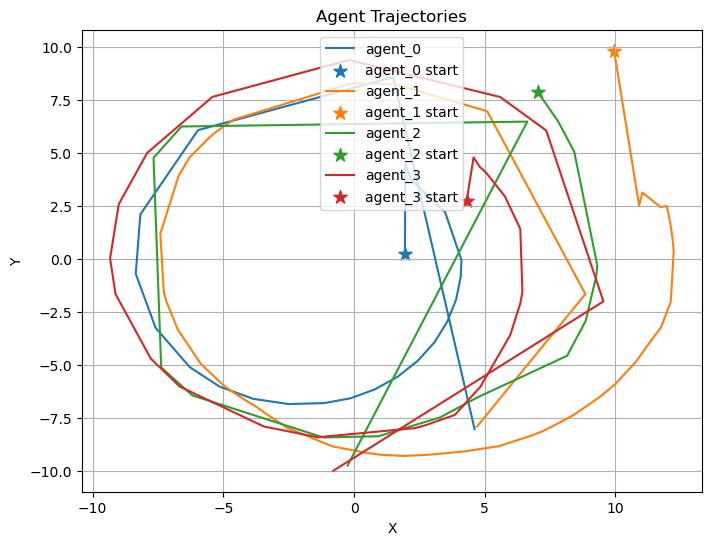

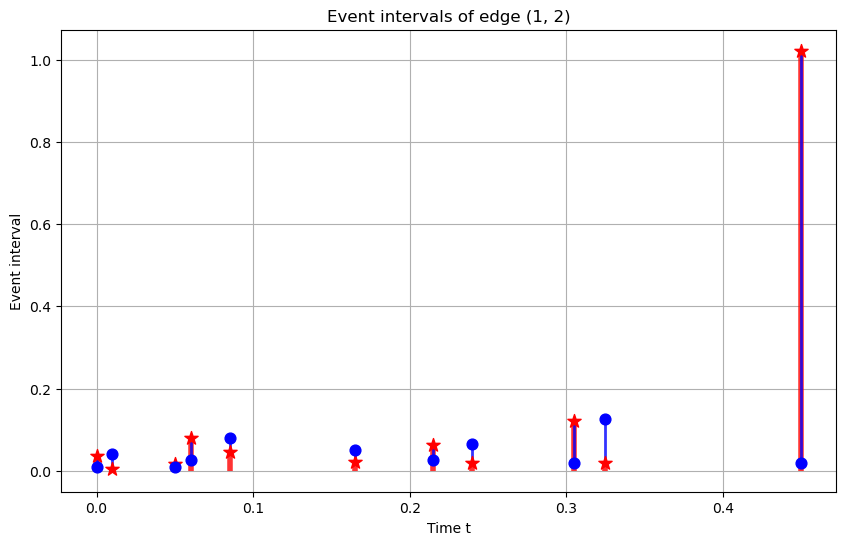

d:\application\anaconda\envs\pytorch\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


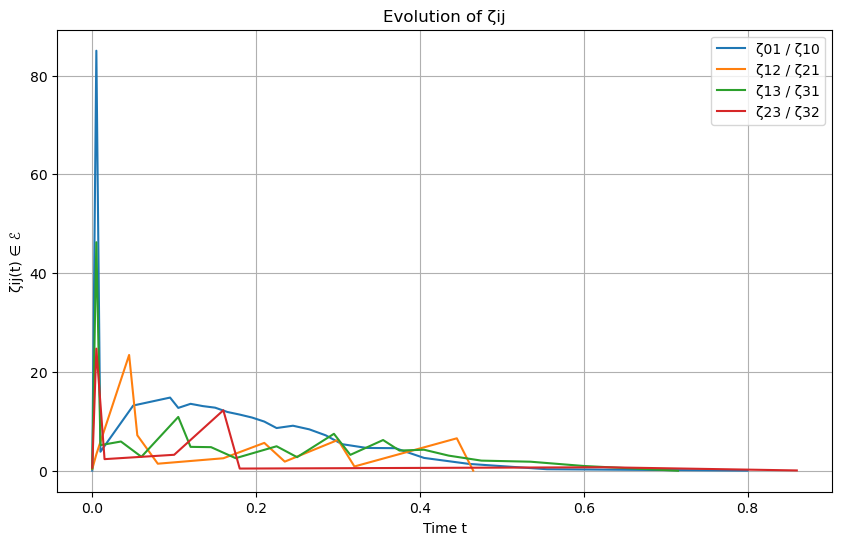

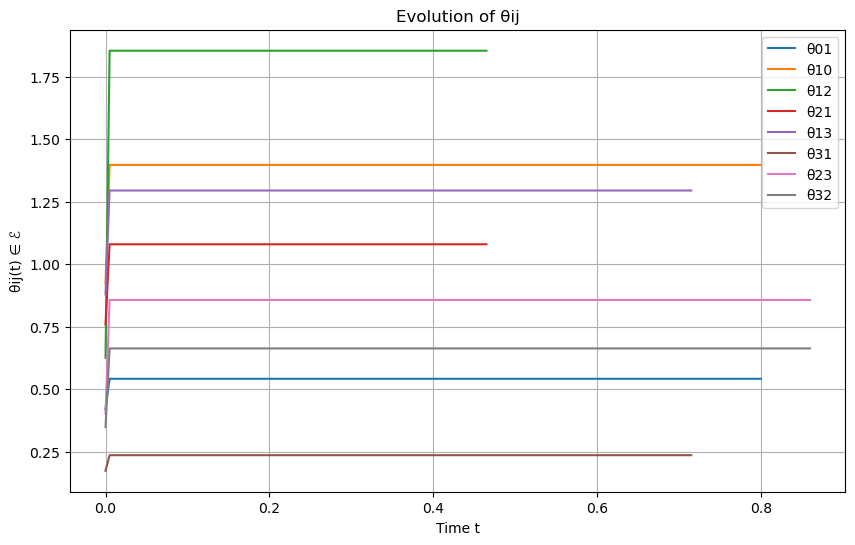

In [4]:
import copy
import agent
import plot
# 仿真参数
delta_t = 0.005  # 时间间隔
T_max = 1  # 仿真运行总时间
alpha = 0.5

# 初始化
num_agents = 4
n = 2
m = 1

# K, gamma, P = get_K_and_Gamma()
agents, edges = init_agents_and_edges(num_agents, delta_t)

# 用来记录所有agent的轨迹
agents_trajectories = {f"agent_{agent_index}" : [] for agent_index in range(num_agents)}
for i in range(num_agents): # 记录agent的初始位置
    i_position = agents[i].position
    agents_trajectories[f"agent_{i}"].append(copy.deepcopy(i_position))


delta_t_tau = {edge: 0 for edge in edges}  # 跟踪每个边自上次事件以来的时间

event_sleep_time = {edge: 0 for edge in edges} # 记录当前边上的睡眠时间，用于判断是否触发通信函数

event_trigger_time = {edge: [] for edge in edges}  # 用来记录事件的触发时间

event_sleep_time_recording = {edge: [] for edge in edges} # 记录每次事件触发后的睡眠时间

delta_t_tau_recording = {edge: [] for edge in edges} # 记录每次事件触发后的自上次事件以来的时间 

edges_zeta_recording = {edge: [] for edge in edges} # 记录每次事件触发后的ζ

edges_theta_recording = {edge: [] for edge in edges} # 记录每次事件触发后的θ

# 记录初始的ζ和θ
for edge in edges:
    event_trigger_time[edge].append(0)
    edges_zeta_recording[edge].append(edge.zeta_ij)
    item = [edge.theta_ij, edge.theta_ji]
    edges_theta_recording[edge].append(item)


# 模拟多智能体系统的动态演化过程
for t in np.arange(0, T_max, delta_t):
    for agent_i in agents:
        # 计算u_i,u_j,更新真实位置
        # item 是所有邻居状态的累积
        u_i_item = get_u_item(agent_i, edges)
        # u_i_item = np.sum([edges[edge].zeta_ij * edges[edge].hz_ij for edge in agent_i.neighbors_edges], axis=0)
        agent_i.update_ut(u_i_item)
        agent_i.update_position()
        agent_i.update_zeta_max(edges)
        
    # for edge in edges:
    #     edge.update_hz()
    #     edge.update_zeta()
    
        
    for edge in edges:
        # 记录每个边自上次事件以来的时间
        delta_t_tau[edge] += delta_t
        
        # ------------状态更新-----------------
        agent_i = edge.head
        agent_j = edge.tail
        
        edge.update_hz()
        edge.update_zeta()
        edge.update_e()
        edge.update_theta()
        edge.update_rho()
        
        # 该边没有达到睡眠时间就退出本次循环
        if delta_t_tau[edge] < event_sleep_time[edge]:
            continue

        # -----达到睡眠时间，看看通信函数是否触发(Φ<0)---------
        if edge.trigger_function() == False:
            continue

        # -----------------通信函数触发---------------------------
        # print(f"-------------agent_{edge.head.index}和agent_{edge.tail.index}边被触发-------------")
        # agent_i.update_zeta_max(edges)
        # agent_j.update_zeta_max(edges)
        
        # 重置e
        edge.reset_e()
        edge.reset_rho()
        # 计算当前边的睡眠时间
        # agent_i.update_zeta_max(edges)
        # agent_j.update_zeta_max(edges)
        sleep_time = edge.calculate_sleeping_time()
        
        # 通信触发，更新edge的真实zij
        edge.update_z(agent_i.position, agent_j.position)
        
        # -------------------------记录参数------------------------------------
        
        # 记录当前边的睡眠时间和自上次事件以来的时间
        event_sleep_time_recording[edge].append(sleep_time)
        delta_t_tau_recording[edge].append(delta_t_tau[edge])
        
        # 记录当前边的触发时刻
        event_trigger_time[edge].append(t)
        
        # 记录当前边的ζ和θ
        edges_zeta_recording[edge].append(edge.zeta_ij)
        item = [edge.theta_ij, edge.theta_ji]
        edges_theta_recording[edge].append(item)


        
        # 记录当前时刻agent_i和agent_j的位置
        i_index = agent_i.index
        i_position = agent_i.position
        # i_position = np.reshape(1, -1)
        agents_trajectories[f"agent_{i_index}"].append(copy.deepcopy(i_position))
        j_index = agent_j.index
        j_position = agent_j.position
        # j_position = np.reshape(1, -1)
        agents_trajectories[f"agent_{j_index}"].append(copy.deepcopy(j_position))
        # print(f"t:{t}")
        # print(f"agent_{i_index}的position:{i_position}")
        # print(f"agent_{j_index}的position:{j_position}")

        # 更新当前边的睡眠时间和上次触发时刻以来的时间delta_t_tau
        event_sleep_time[edge] = sleep_time
        delta_t_tau[edge] = 0 


# for agent in agents:
#     print(agent.index)
#     print(agent.position)
#     print(agent.neighbors_num)
#     print(agent.neighbors_edges)
# print("agents_trajectories:")
# for key in agents_trajectories.keys():
#     print(key + ":")
#     print(agents_trajectories[key])

plot.plot_agent_trajectories(agents_trajectories)
# print(f"event_sleep_time_recording[edges[1]]：{event_sleep_time_recording[edges[1]]}")
# 绘制edge（1，2） 的触发时间间隔
plot.plot_event_intervals(edges[1].head.index, edges[1].tail.index, event_sleep_time_recording[edges[1]], delta_t_tau_recording[edges[1]])
plot.plot_evolution(event_trigger_time, edges_zeta_recording)
plot.plot_theta_evolution(event_trigger_time, edges_theta_recording)